### MASKED + WEIGHTED + VARIANCE + RANDOM + SYMMETRIZATION $\kappa$ MAP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter
from helper import preprocess_catalog_galactic
from helper import load_catalog
from helper import symmetrize_map
from helper import radial_profile
import pandas as pd

In [2]:
# --- Settings ---
dataset = "BOSS"
if dataset == "eBOSS":
    catalog, region = "LRG", "NGC"
    real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
    rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
elif dataset == "BOSS":
    catalog, region = "CMASS", "North"
    real_file = f"data/BOSS/galaxy_DR12v5_CMASS_{region}.fits"
    rand_file = f"data/BOSS/random0_DR12v5_CMASS_{region}.fits"
else:
    raise ValueError("dataset must be eBOSS or BOSS")

alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [3]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100.0
h = cosmo.h
grid_size = 100
cell_size_hmpc = box_size_hmpc / grid_size
half_box_hmpc = box_size_hmpc / 2
extent = [-half_box_hmpc, half_box_hmpc, -half_box_hmpc, half_box_hmpc]

offsets = np.linspace(-half_box_hmpc + cell_size_hmpc/2,
                      half_box_hmpc - cell_size_hmpc/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [4]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

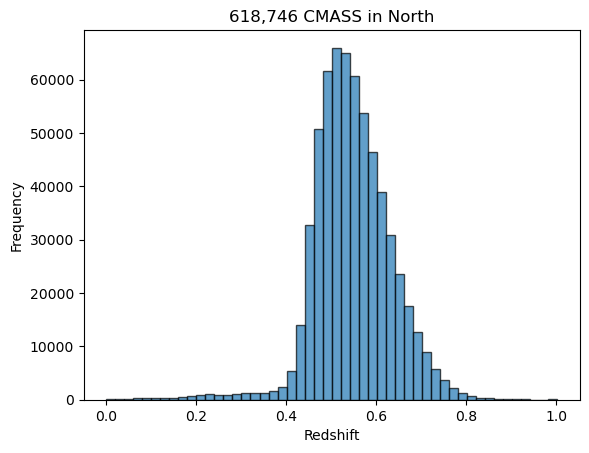

In [5]:
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- Load eBOSS LRG catalog ---
with fits.open(real_file) as hd:
    data = hd[1].data

# --- Filter out invalid galaxies ---
data = data[data['Z'] > 0]
data = data[np.isfinite(data['RA']) & np.isfinite(data['DEC'])]

# --- Load and smooth Planck κ alm ---
alms = fits.open("data/COM_Lensing_4096_R3.00/MV/dat_klm.fits")[1].data
alm = alms['REAL'] + 1j * alms['IMAG']
lmax = hp.Alm.getlmax(len(alm))
nside = 2048

# --- Redshift histogram ---
zs = [gal['Z'] for gal in data]
plt.hist(zs, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title(f"{len(zs):,} {catalog} in {region}")
plt.show()

In [6]:
def assign_jackknife_regions_healpix(catalog, rand_cat, nside=10, threshold=0.9):
    rand_coord = SkyCoord(ra=rand_cat['RA']*u.deg, dec=rand_cat['DEC']*u.deg)
    rand_pix = hp.ang2pix(nside, np.radians(90 - rand_coord.dec.value), np.radians(rand_coord.ra.value))

    unique, counts = np.unique(rand_pix, return_counts=True)
    mean_density = np.mean(counts)
    good_pix = unique[counts > threshold * mean_density]

    gal_coord = SkyCoord(ra=catalog['RA']*u.deg, dec=catalog['DEC']*u.deg)
    gal_pix = hp.ang2pix(nside, np.radians(90 - gal_coord.dec.value), np.radians(gal_coord.ra.value))

    mask = np.isin(gal_pix, good_pix)
    return gal_pix[mask], mask

In [7]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    # --- Preprocess only valid galaxies and convert to Galactic ---
    l_arr, b_arr, D_arr, data, weights_valid = preprocess_catalog_galactic(data, weights)
    # weights = weights[:len(data)]  # Ensure weights match filtered data

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        cosb = np.cos(np.radians(b))
        dl = (off_x / D) * (180 / np.pi) / np.clip(cosb, 1e-6, None)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        # if np.minimum(theta) < 0:
            # print(f"{i}: Theta less than zero encountered: {np.min(theta)}")
            # continue
        # if np.maximum(theta) > np.pi:
            # print(f"{i}: Theta greater than zero encountered: {np.max(theta)}")
            # continue
        phi = np.radians(l_grid)
        theta = np.clip(theta, 0, np.pi)  # Ensure valid range
        pix = hp.ang2pix(nside, theta, phi)

        w = weights_valid[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_wk2 += w * κ_vals**2
        sum_w += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [8]:
def jackknife_stack_healpix(data, weights, rand_cat, nside=10, threshold=0.9):
    print("Assigning jackknife regions...")
    jk_regions, valid_mask = assign_jackknife_regions_healpix(data, rand_cat, nside, threshold)
    data, weights = data[valid_mask], weights[valid_mask]
    unique_regions = np.unique(jk_regions)

    kappa_jk = []

    for reg in tqdm(unique_regions, desc="Jackknife (HEALPix)"):
        mask_jk = jk_regions != reg
        data_jk = data[mask_jk]
        weights_jk = weights[mask_jk]
        kappa, _, _ = stack_kappa(data_jk, weights_jk, f"JK-{reg}")
        kappa_jk.append(kappa)

    kappa_jk = np.array(kappa_jk)
    kappa_mean = np.mean(kappa_jk, axis=0)
    kappa_err = np.sqrt((len(kappa_jk) - 1) / len(kappa_jk) * np.sum((kappa_jk - kappa_mean)**2, axis=0))

    return kappa_mean, kappa_err

In [9]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
    plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [10]:
# --- Run all ---
if dataset == "BOSS":
    z_min = .4
    z_max = .7
    weight = "CMASS"
else: # eBOSS
    z_min = 0
    z_max = 10000
    weight = True
print("Loading catalogs...")
data_real, w_real = load_catalog(real_file, weights=weight, z_min=z_min, z_max=z_max)
print("Loading random catalogs...")
data_rand, w_rand = load_catalog(rand_file, weights=False, random_fraction=0.10, z_min=z_min, z_max=z_max)

# Jackknife real galaxies
kappa_real, sigma_real = jackknife_stack_healpix(data_real, w_real, data_rand, nside=10)
sn_real = np.zeros_like(kappa_real)
valid = sigma_real > 0
sn_real[valid] = kappa_real[valid] / sigma_real[valid]
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
# kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Loading catalogs...
Loading random catalogs...
Assigning jackknife regions...


Jackknife (HEALPix):   0%|          | 0/200 [00:00<?, ?it/s]

Stacking JK-49:   0%|          | 0/532441 [00:00<?, ?it/s]

Stacking JK-50:   0%|          | 0/532296 [00:00<?, ?it/s]

Stacking JK-69:   0%|          | 0/532292 [00:00<?, ?it/s]

Stacking JK-70:   0%|          | 0/532095 [00:00<?, ?it/s]

Stacking JK-71:   0%|          | 0/531983 [00:00<?, ?it/s]

Stacking JK-72:   0%|          | 0/531782 [00:00<?, ?it/s]

Stacking JK-73:   0%|          | 0/531555 [00:00<?, ?it/s]

Stacking JK-74:   0%|          | 0/531761 [00:00<?, ?it/s]

Stacking JK-94:   0%|          | 0/531904 [00:00<?, ?it/s]

Stacking JK-95:   0%|          | 0/532323 [00:00<?, ?it/s]

Stacking JK-96:   0%|          | 0/531610 [00:00<?, ?it/s]

Stacking JK-97:   0%|          | 0/531726 [00:00<?, ?it/s]

Stacking JK-98:   0%|          | 0/531787 [00:00<?, ?it/s]

Stacking JK-99:   0%|          | 0/531442 [00:00<?, ?it/s]

Stacking JK-100:   0%|          | 0/531548 [00:00<?, ?it/s]

Stacking JK-101:   0%|          | 0/531782 [00:00<?, ?it/s]

Stacking JK-102:   0%|          | 0/532210 [00:00<?, ?it/s]

Stacking JK-123:   0%|          | 0/532294 [00:00<?, ?it/s]

Stacking JK-124:   0%|          | 0/531600 [00:00<?, ?it/s]

Stacking JK-125:   0%|          | 0/531562 [00:00<?, ?it/s]

Stacking JK-126:   0%|          | 0/531333 [00:00<?, ?it/s]

Stacking JK-127:   0%|          | 0/531785 [00:00<?, ?it/s]

Stacking JK-128:   0%|          | 0/531968 [00:00<?, ?it/s]

Stacking JK-129:   0%|          | 0/531598 [00:00<?, ?it/s]

Stacking JK-130:   0%|          | 0/531362 [00:00<?, ?it/s]

Stacking JK-131:   0%|          | 0/531149 [00:00<?, ?it/s]

Stacking JK-132:   0%|          | 0/531753 [00:00<?, ?it/s]

Stacking JK-133:   0%|          | 0/532059 [00:00<?, ?it/s]

Stacking JK-156:   0%|          | 0/532088 [00:00<?, ?it/s]

Stacking JK-157:   0%|          | 0/532052 [00:00<?, ?it/s]

Stacking JK-158:   0%|          | 0/531697 [00:00<?, ?it/s]

Stacking JK-159:   0%|          | 0/531217 [00:00<?, ?it/s]

Stacking JK-160:   0%|          | 0/531367 [00:00<?, ?it/s]

Stacking JK-161:   0%|          | 0/531853 [00:00<?, ?it/s]

Stacking JK-162:   0%|          | 0/531387 [00:00<?, ?it/s]

Stacking JK-163:   0%|          | 0/531461 [00:00<?, ?it/s]

Stacking JK-164:   0%|          | 0/531905 [00:00<?, ?it/s]

Stacking JK-165:   0%|          | 0/531744 [00:00<?, ?it/s]

Stacking JK-166:   0%|          | 0/531363 [00:00<?, ?it/s]

Stacking JK-167:   0%|          | 0/531712 [00:00<?, ?it/s]

Stacking JK-168:   0%|          | 0/532001 [00:00<?, ?it/s]

Stacking JK-193:   0%|          | 0/532026 [00:00<?, ?it/s]

Stacking JK-194:   0%|          | 0/531898 [00:00<?, ?it/s]

Stacking JK-195:   0%|          | 0/532157 [00:00<?, ?it/s]

Stacking JK-196:   0%|          | 0/531421 [00:00<?, ?it/s]

Stacking JK-197:   0%|          | 0/531928 [00:00<?, ?it/s]

Stacking JK-198:   0%|          | 0/531727 [00:00<?, ?it/s]

Stacking JK-199:   0%|          | 0/531596 [00:00<?, ?it/s]

Stacking JK-200:   0%|          | 0/531713 [00:00<?, ?it/s]

Stacking JK-201:   0%|          | 0/531581 [00:00<?, ?it/s]

Stacking JK-202:   0%|          | 0/532009 [00:00<?, ?it/s]

Stacking JK-203:   0%|          | 0/531578 [00:00<?, ?it/s]

Stacking JK-204:   0%|          | 0/532070 [00:00<?, ?it/s]

Stacking JK-206:   0%|          | 0/531687 [00:00<?, ?it/s]

Stacking JK-207:   0%|          | 0/531832 [00:00<?, ?it/s]

Stacking JK-233:   0%|          | 0/531708 [00:00<?, ?it/s]

Stacking JK-234:   0%|          | 0/531807 [00:00<?, ?it/s]

Stacking JK-235:   0%|          | 0/532016 [00:00<?, ?it/s]

Stacking JK-236:   0%|          | 0/531777 [00:00<?, ?it/s]

Stacking JK-237:   0%|          | 0/531669 [00:00<?, ?it/s]

Stacking JK-238:   0%|          | 0/531867 [00:00<?, ?it/s]

Stacking JK-239:   0%|          | 0/531647 [00:00<?, ?it/s]

Stacking JK-240:   0%|          | 0/531444 [00:00<?, ?it/s]

Stacking JK-241:   0%|          | 0/531536 [00:00<?, ?it/s]

Stacking JK-242:   0%|          | 0/531994 [00:00<?, ?it/s]

Stacking JK-243:   0%|          | 0/531631 [00:00<?, ?it/s]

Stacking JK-244:   0%|          | 0/531496 [00:00<?, ?it/s]

Stacking JK-245:   0%|          | 0/531788 [00:00<?, ?it/s]

Stacking JK-246:   0%|          | 0/531976 [00:00<?, ?it/s]

Stacking JK-247:   0%|          | 0/531961 [00:00<?, ?it/s]

Stacking JK-248:   0%|          | 0/532180 [00:00<?, ?it/s]

Stacking JK-273:   0%|          | 0/531723 [00:00<?, ?it/s]

Stacking JK-274:   0%|          | 0/531891 [00:00<?, ?it/s]

Stacking JK-275:   0%|          | 0/531875 [00:00<?, ?it/s]

Stacking JK-276:   0%|          | 0/531529 [00:00<?, ?it/s]

Stacking JK-277:   0%|          | 0/531602 [00:00<?, ?it/s]

Stacking JK-278:   0%|          | 0/532014 [00:00<?, ?it/s]

Stacking JK-279:   0%|          | 0/531906 [00:00<?, ?it/s]

Stacking JK-280:   0%|          | 0/531984 [00:00<?, ?it/s]

Stacking JK-281:   0%|          | 0/531898 [00:00<?, ?it/s]

Stacking JK-282:   0%|          | 0/532033 [00:00<?, ?it/s]

Stacking JK-283:   0%|          | 0/531598 [00:00<?, ?it/s]

Stacking JK-284:   0%|          | 0/531561 [00:00<?, ?it/s]

Stacking JK-285:   0%|          | 0/532172 [00:00<?, ?it/s]

Stacking JK-286:   0%|          | 0/531940 [00:00<?, ?it/s]

Stacking JK-287:   0%|          | 0/532143 [00:00<?, ?it/s]

Stacking JK-288:   0%|          | 0/532150 [00:00<?, ?it/s]

Stacking JK-313:   0%|          | 0/532405 [00:00<?, ?it/s]

Stacking JK-314:   0%|          | 0/531716 [00:00<?, ?it/s]

Stacking JK-315:   0%|          | 0/531429 [00:00<?, ?it/s]

Stacking JK-316:   0%|          | 0/531653 [00:00<?, ?it/s]

Stacking JK-317:   0%|          | 0/531685 [00:00<?, ?it/s]

Stacking JK-318:   0%|          | 0/531533 [00:00<?, ?it/s]

Stacking JK-319:   0%|          | 0/531706 [00:00<?, ?it/s]

Stacking JK-320:   0%|          | 0/531154 [00:00<?, ?it/s]

Stacking JK-321:   0%|          | 0/531442 [00:00<?, ?it/s]

Stacking JK-322:   0%|          | 0/532126 [00:00<?, ?it/s]

Stacking JK-323:   0%|          | 0/531877 [00:00<?, ?it/s]

Stacking JK-324:   0%|          | 0/531862 [00:00<?, ?it/s]

Stacking JK-325:   0%|          | 0/532261 [00:00<?, ?it/s]

Stacking JK-326:   0%|          | 0/531551 [00:00<?, ?it/s]

Stacking JK-327:   0%|          | 0/531595 [00:00<?, ?it/s]

Stacking JK-328:   0%|          | 0/532020 [00:00<?, ?it/s]

Stacking JK-353:   0%|          | 0/532001 [00:00<?, ?it/s]

Stacking JK-354:   0%|          | 0/532038 [00:00<?, ?it/s]

Stacking JK-355:   0%|          | 0/531881 [00:00<?, ?it/s]

Stacking JK-356:   0%|          | 0/531784 [00:00<?, ?it/s]

Stacking JK-357:   0%|          | 0/531737 [00:00<?, ?it/s]

Stacking JK-358:   0%|          | 0/531891 [00:00<?, ?it/s]

Stacking JK-359:   0%|          | 0/531537 [00:00<?, ?it/s]

Stacking JK-360:   0%|          | 0/531506 [00:00<?, ?it/s]

Stacking JK-361:   0%|          | 0/531525 [00:00<?, ?it/s]

Stacking JK-362:   0%|          | 0/531870 [00:00<?, ?it/s]

Stacking JK-363:   0%|          | 0/531685 [00:00<?, ?it/s]

Stacking JK-364:   0%|          | 0/532041 [00:00<?, ?it/s]

Stacking JK-365:   0%|          | 0/531730 [00:00<?, ?it/s]

Stacking JK-366:   0%|          | 0/531744 [00:00<?, ?it/s]

Stacking JK-367:   0%|          | 0/532191 [00:00<?, ?it/s]

Stacking JK-368:   0%|          | 0/532629 [00:00<?, ?it/s]

Stacking JK-393:   0%|          | 0/532171 [00:00<?, ?it/s]

Stacking JK-394:   0%|          | 0/532256 [00:00<?, ?it/s]

Stacking JK-395:   0%|          | 0/531771 [00:00<?, ?it/s]

Stacking JK-396:   0%|          | 0/531914 [00:00<?, ?it/s]

Stacking JK-397:   0%|          | 0/531782 [00:00<?, ?it/s]

Stacking JK-398:   0%|          | 0/531639 [00:00<?, ?it/s]

Stacking JK-399:   0%|          | 0/531748 [00:00<?, ?it/s]

Stacking JK-400:   0%|          | 0/531537 [00:00<?, ?it/s]

Stacking JK-401:   0%|          | 0/531709 [00:00<?, ?it/s]

Stacking JK-402:   0%|          | 0/531708 [00:00<?, ?it/s]

Stacking JK-403:   0%|          | 0/531583 [00:00<?, ?it/s]

Stacking JK-404:   0%|          | 0/531914 [00:00<?, ?it/s]

Stacking JK-405:   0%|          | 0/531787 [00:00<?, ?it/s]

Stacking JK-406:   0%|          | 0/531955 [00:00<?, ?it/s]

Stacking JK-407:   0%|          | 0/532027 [00:00<?, ?it/s]

Stacking JK-408:   0%|          | 0/532098 [00:00<?, ?it/s]

Stacking JK-433:   0%|          | 0/531985 [00:00<?, ?it/s]

Stacking JK-434:   0%|          | 0/532172 [00:00<?, ?it/s]

Stacking JK-435:   0%|          | 0/531565 [00:00<?, ?it/s]

Stacking JK-436:   0%|          | 0/532027 [00:00<?, ?it/s]

Stacking JK-437:   0%|          | 0/531747 [00:00<?, ?it/s]

Stacking JK-438:   0%|          | 0/531705 [00:00<?, ?it/s]

Stacking JK-439:   0%|          | 0/531514 [00:00<?, ?it/s]

Stacking JK-440:   0%|          | 0/531829 [00:00<?, ?it/s]

Stacking JK-441:   0%|          | 0/531416 [00:00<?, ?it/s]

Stacking JK-442:   0%|          | 0/531588 [00:00<?, ?it/s]

Stacking JK-443:   0%|          | 0/531959 [00:00<?, ?it/s]

Stacking JK-444:   0%|          | 0/531760 [00:00<?, ?it/s]

Stacking JK-445:   0%|          | 0/531948 [00:00<?, ?it/s]

Stacking JK-446:   0%|          | 0/531719 [00:00<?, ?it/s]

Stacking JK-447:   0%|          | 0/531939 [00:00<?, ?it/s]

Stacking JK-474:   0%|          | 0/532366 [00:00<?, ?it/s]

Stacking JK-475:   0%|          | 0/532083 [00:00<?, ?it/s]

Stacking JK-476:   0%|          | 0/531909 [00:00<?, ?it/s]

Stacking JK-477:   0%|          | 0/531661 [00:00<?, ?it/s]

Stacking JK-478:   0%|          | 0/531974 [00:00<?, ?it/s]

Stacking JK-479:   0%|          | 0/531892 [00:00<?, ?it/s]

Stacking JK-480:   0%|          | 0/531574 [00:00<?, ?it/s]

Stacking JK-481:   0%|          | 0/531487 [00:00<?, ?it/s]

Stacking JK-482:   0%|          | 0/531964 [00:00<?, ?it/s]

Stacking JK-483:   0%|          | 0/531777 [00:00<?, ?it/s]

Stacking JK-484:   0%|          | 0/531587 [00:00<?, ?it/s]

Stacking JK-485:   0%|          | 0/531997 [00:00<?, ?it/s]

Stacking JK-486:   0%|          | 0/531867 [00:00<?, ?it/s]

Stacking JK-487:   0%|          | 0/531959 [00:00<?, ?it/s]

Stacking JK-514:   0%|          | 0/531954 [00:00<?, ?it/s]

Stacking JK-515:   0%|          | 0/531543 [00:00<?, ?it/s]

Stacking JK-516:   0%|          | 0/531818 [00:00<?, ?it/s]

Stacking JK-517:   0%|          | 0/532006 [00:00<?, ?it/s]

Stacking JK-518:   0%|          | 0/531653 [00:00<?, ?it/s]

Stacking JK-519:   0%|          | 0/531653 [00:00<?, ?it/s]

Stacking JK-520:   0%|          | 0/531536 [00:00<?, ?it/s]

Stacking JK-521:   0%|          | 0/531964 [00:00<?, ?it/s]

Stacking JK-522:   0%|          | 0/531380 [00:00<?, ?it/s]

Stacking JK-523:   0%|          | 0/531870 [00:00<?, ?it/s]

Stacking JK-524:   0%|          | 0/531475 [00:00<?, ?it/s]

Stacking JK-525:   0%|          | 0/531565 [00:00<?, ?it/s]

Stacking JK-526:   0%|          | 0/531916 [00:00<?, ?it/s]

Stacking JK-554:   0%|          | 0/531656 [00:00<?, ?it/s]

Stacking JK-555:   0%|          | 0/531878 [00:00<?, ?it/s]

Stacking JK-556:   0%|          | 0/531880 [00:00<?, ?it/s]

Stacking JK-557:   0%|          | 0/532343 [00:00<?, ?it/s]

Stacking JK-558:   0%|          | 0/532235 [00:00<?, ?it/s]

Stacking JK-560:   0%|          | 0/531975 [00:00<?, ?it/s]

Stacking JK-561:   0%|          | 0/531712 [00:00<?, ?it/s]

Stacking JK-562:   0%|          | 0/531976 [00:00<?, ?it/s]

Stacking JK-563:   0%|          | 0/531611 [00:00<?, ?it/s]

Stacking JK-564:   0%|          | 0/531908 [00:00<?, ?it/s]

Stacking JK-565:   0%|          | 0/532093 [00:00<?, ?it/s]

Stacking JK-566:   0%|          | 0/532219 [00:00<?, ?it/s]

Stacking JK-595:   0%|          | 0/531934 [00:00<?, ?it/s]

Stacking JK-596:   0%|          | 0/532185 [00:00<?, ?it/s]

Stacking JK-597:   0%|          | 0/532237 [00:00<?, ?it/s]

Stacking JK-598:   0%|          | 0/532290 [00:00<?, ?it/s]

Stacking JK-599:   0%|          | 0/532408 [00:00<?, ?it/s]

Stacking JK-600:   0%|          | 0/532579 [00:00<?, ?it/s]

Stacking JK-601:   0%|          | 0/531922 [00:00<?, ?it/s]

Stacking JK-602:   0%|          | 0/531558 [00:00<?, ?it/s]

Stacking JK-603:   0%|          | 0/531642 [00:00<?, ?it/s]

Stacking JK-604:   0%|          | 0/531585 [00:00<?, ?it/s]

Stacking JK-605:   0%|          | 0/532779 [00:00<?, ?it/s]

Stacking Random:   0%|          | 0/3011334 [00:00<?, ?it/s]

/Users/carolinewu/PycharmProjects/astrophysics/helper.py:113: RuntimeWarning: invalid value encountered in divide
  kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)


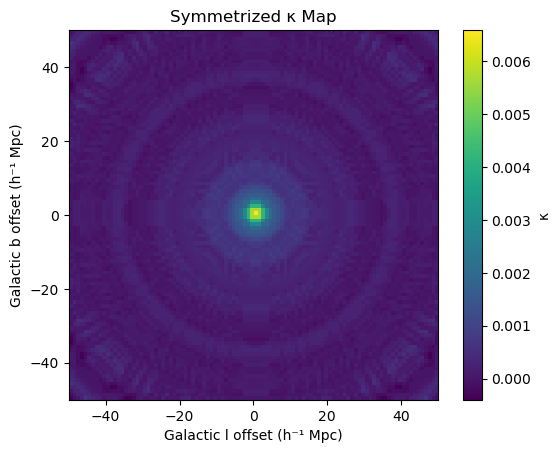

In [11]:
kappa_sym = symmetrize_map(kappa_sub)
plot_map(kappa_sym, "Symmetrized κ Map", cmap='viridis')

In [12]:
pd.DataFrame(kappa_sym).to_csv(r"data/kappa_control_BOSS_North.csv", index=True)

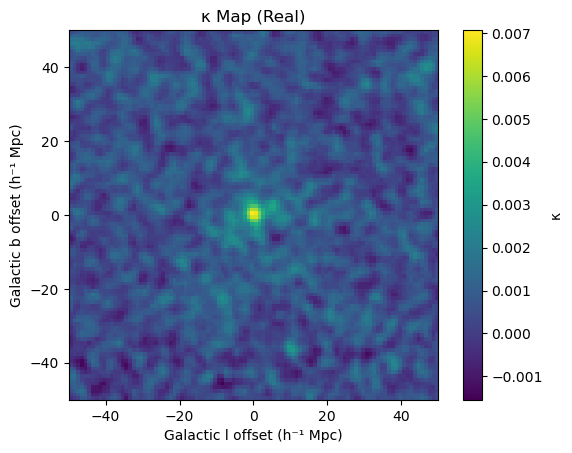

In [13]:
# --- Plots ---
plot_map(kappa_real, "κ Map (Real)")

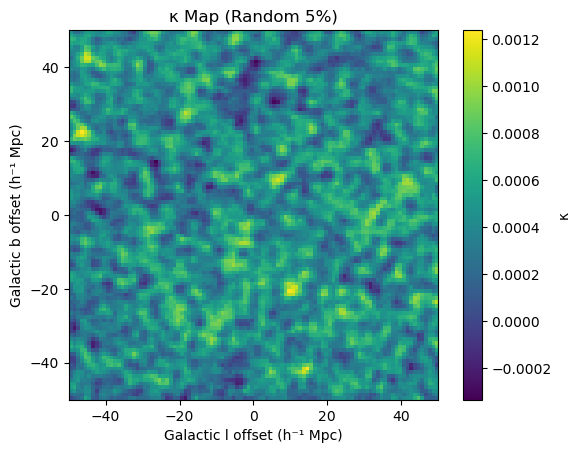

In [14]:
plot_map(kappa_rand, "κ Map (Random 5%)")

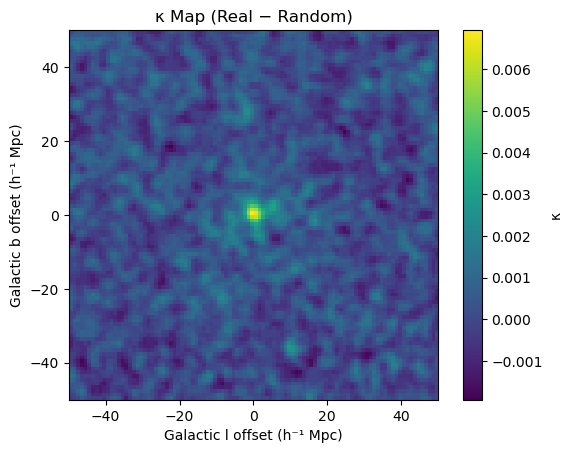

In [15]:
plot_map(kappa_sub, "κ Map (Real − Random)")

In [16]:
# plot_map(kappa_smooth, "Smoothed κ Map", cmap='viridis')

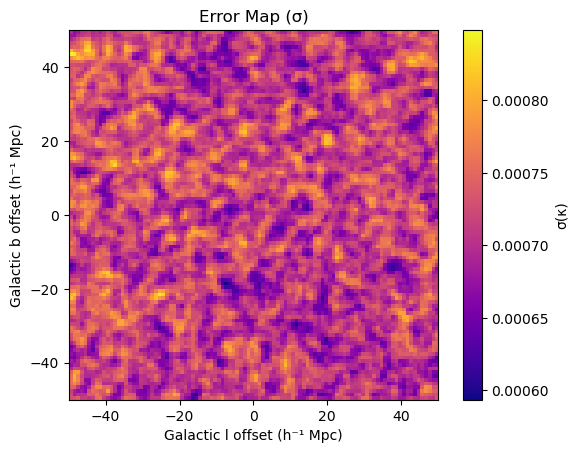

In [17]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

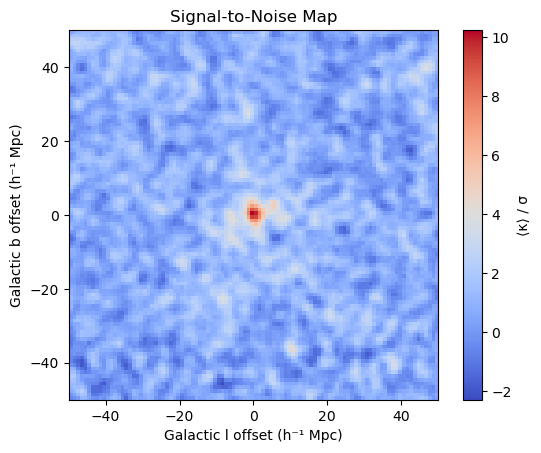

In [18]:
plot_map(sn_real, "Signal-to-Noise Map", cmap='coolwarm', label='⟨κ⟩ / σ')

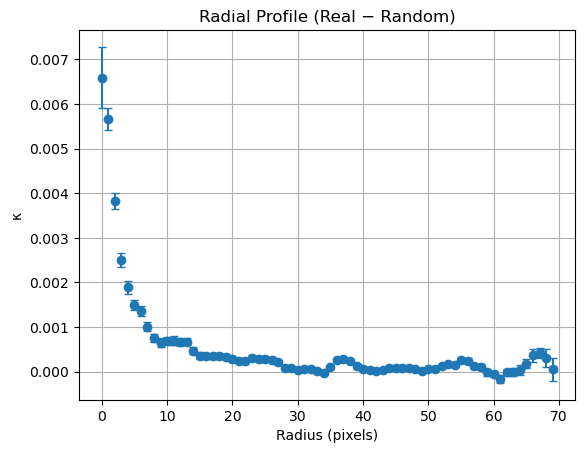

In [19]:
profile, errs = radial_profile(kappa_sub, sigma_real, "Radial Profile (Real − Random)", zoom=70)
np.save("old_sub_radial.npy", profile)

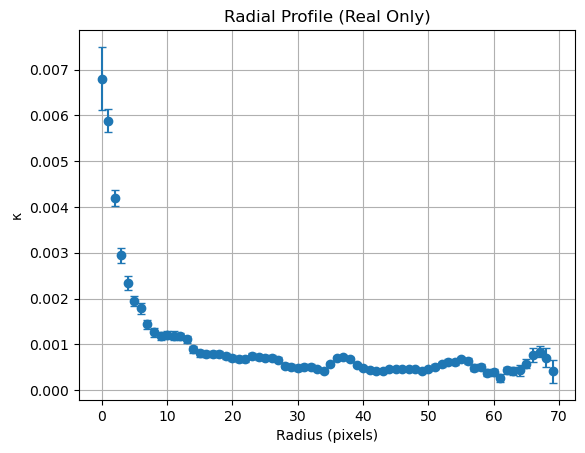

In [20]:
profile, errs = radial_profile(kappa_real, sigma_real, "Radial Profile (Real Only)", zoom=70)
np.save("old_real_radial.npy", profile)

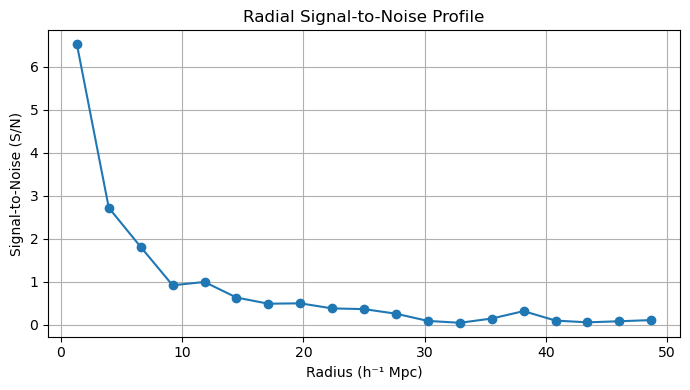

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Use your existing stacked maps here:
kappa_mean = kappa_sub       # 2D array, shape (grid_size, grid_size)
kappa_sigma = sigma_real     # 2D array, same shape

grid_size = kappa_mean.shape[0]  # e.g. 100
box_size_hmpc = 100  # your box size in h^-1 Mpc

# Create coordinate grids in Mpc
x = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
y = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
X, Y = np.meshgrid(x, y)

# Compute radius from center in Mpc
R = np.sqrt(X**2 + Y**2)

# Flatten arrays for binning
r_flat = R.ravel()
signal_flat = kappa_mean.ravel()
sigma_flat = kappa_sigma.ravel()

# Define radial bins (e.g., 20 bins up to 50 Mpc)
bin_edges = np.linspace(0, box_size_hmpc/2, 20)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Digitize radii to bins
inds = np.digitize(r_flat, bin_edges)

# Compute S/N per bin
sn_profile = []
for i in range(1, len(bin_edges)):
    in_bin = (inds == i)
    if np.any(in_bin):
        mean_signal = np.mean(signal_flat[in_bin])
        mean_sigma = np.sqrt(np.mean(sigma_flat[in_bin]**2))
        sn_profile.append(mean_signal / mean_sigma if mean_sigma > 0 else 0)
    else:
        sn_profile.append(0)

# Plot radial S/N profile
plt.figure(figsize=(7,4))
plt.plot(bin_centers, sn_profile, marker='o')
plt.xlabel('Radius (h⁻¹ Mpc)')
plt.ylabel('Signal-to-Noise (S/N)')
plt.title('Radial Signal-to-Noise Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# --- Diagnostics ---
print("Diagnostics:")
print(f"κ min: {np.min(kappa_sub):.4g}, max: {np.max(kappa_sub):.4g}")
print(f"σ min: {np.min(sigma_real):.4g}, max: {np.max(sigma_real):.4g}")
print(f"S/N min: {np.min(sn_real):.4g}, max: {np.max(sn_real):.4g}")

Diagnostics:
κ min: -0.001934, max: 0.006946
σ min: 0.0005935, max: 0.0008485
S/N min: -2.292, max: 10.25
